In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingRegressor, RandomForestRegressor, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# model evaluation
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc, f1_score
# dataset visulization
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# data resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
# feature selection
from sklearn.feature_selection import VarianceThreshold, RFE, mutual_info_classif, SelectKBest
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
# model selection
from sklearn.model_selection import StratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier 

### ROC_AUC_Curve Function
Using the default settings, probabilities of 0.5 or above are assigned a class label of 1.0 and those below are assigned a 0.0. However, this threshold can be adjusted. The receiver operating characteristic curve (ROC curve) plots the false positive rate and true positive rate at different thresholds. ROC curves are judged visually by how close they are to the upper lefthand corner.

The area under the curve (AUC) is also calculated, where 1 means every predicted label was correct. Generally, the worst score for AUC is 0.5, which is the performance of a model that randomly guesses. See the scikit-learn documentation for more resources and examples on ROC curves and AUC.

In [3]:
def ROC_AUC_Curve(probabilities,y_test):
    # select the probabilities for label 1.0
    y_proba = probabilities[:,1]
    # calculate false positive rate and true positive rate at different thresholds
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)
    # calculate AUC
    roc_auc = auc(false_positive_rate,true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    # plot the false positive rate on the x axis and the true positive rate on the y axis
    roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))
    plt.legend(loc=0)
    plt.plot([0,1], [0,1], ls='--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate');
    plt.show()

# Data Loading and process
- load data and check pupulation size
- split data to train and test data
- visualize high-dimensional datase by t-SNE and PCA

### load data and check pupulation size
- df: original data
- df_rename: 'Bankrupt?' : 'target', features: Attr1~Attr95

In [47]:
# Read in dataset
df = pd.read_csv('data.csv')
df_rename = df.copy()
population_size = len(df)
# Rename columns
df.rename(columns={'Bankrupt?' : 'target'},inplace=True)
index = 0
for col in df_rename.columns:
    if col == 'Bankrupt?':
        df_rename.rename(columns={col : 'target'},inplace=True)
    else:
        df_rename.rename(columns={col : 'Attr'+str(index)},inplace=True)
    index += 1    

# Checking data population
print("data shape:",df_rename.shape)
# Checking target incidence
print("\ndata incidence",df_rename.target.value_counts(normalize=True))

#basetable.columns

data shape: (6819, 96)

data incidence 0    0.967737
1    0.032263
Name: target, dtype: float64


$\implies$ 3% of target '1': imbalanced data</br>
$\implies$ 96 features: high-dimensional dataset


### split data to train and test data
- X: all features data
- y: target data
- X_train, X_test, y_train, y_teat splited by 'train_test_split' with test-size 0.3

In [48]:
# Assign Data to X and y
X = df_rename.drop(columns='target')
y = df_rename.target

### visualize high-dimensional datase
- t-SNE: https://youtu.be/NEaUSP4YerM
- PCA(Principal Component Analysi)

#### t-SNE Visulization

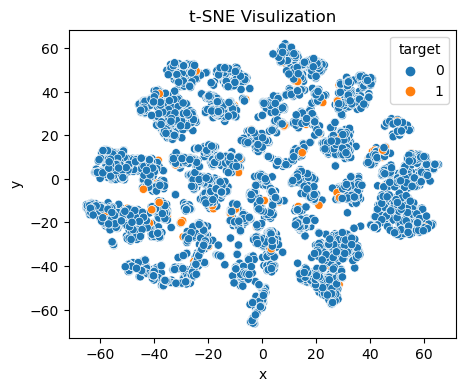

In [40]:
def tSNE_visu(X, y):
    data_TSNE = X.copy()
    data_TSNE['target'] = y
    # Create a t-SNE model with learning rate 50
    m = TSNE(learning_rate=50)
    # Fit and transform the t-SNE model on the numeric dataset
    tsne_features = m.fit_transform(X)
    data_TSNE['x'] = tsne_features[:,0]
    data_TSNE['y'] = tsne_features[:,1]
    plt.figure(figsize=(5, 4))
    sns.scatterplot(x="x", y="y", hue='target', data=data_TSNE)
    plt.title('t-SNE Visulization',fontsize=12)
    plt.show()
    
tSNE_visu(X, y)

#### PCA Visulization

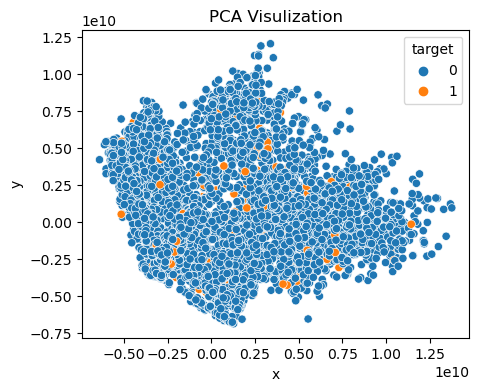

In [7]:
# PCA before scalung
def PCA_visu(X,y):
    data_PCA = X.copy()
    data_PCA['target'] = y
    pca = PCA()
    pca_features = pca.fit_transform(X)
    data_PCA['x'] = pca_features[:,0]
    data_PCA['y'] = pca_features[:,1]
    plt.figure(figsize=(5, 4))
    sns.scatterplot(x="x", y="y", hue='target', data=data_PCA)
    plt.title('PCA Visulization',fontsize=12)
    plt.show()

PCA_visu(X,y)

## Resample Imbalanced data
- Using imblearn library </br>
  1. Undersampling: </br>This technique eliminates or deletes the data points of the majority class to make an equal ratio of major and minor classes.There is a various method for undersampling like Tomek’s links, EditedNearestNeighbours, CondensedNearestNeighbour, InstanceHardnessThreshold, etc.
  2. Oversampling: </br>This technique redistributes randomly the minority class data points to increase the ratio in the dataset.It duplicates the existing data points of minority class and equalizes the ratio of majority and minority class.
  3. SMOTE (Synthetic Minority Oversampling Technique):</br>SMOTE selects the data points of the minority class in feature space to draw a line between those points and generate new points along with the line. Thus this technique synthesizes new data points for minority class and oversample that class.</br>This is the most effective method for oversampling.
  4. ADASYN:</br>This method is similar to SMOTE but it generates different number of samples depending on an estimate of the local distribution of the class to be oversampled.

### Undersampling

X_underSampling's shape: (440, 95) y_underSampling's shape: (440,)
y_underSampling:
 0    0.5
1    0.5
Name: target, dtype: float64


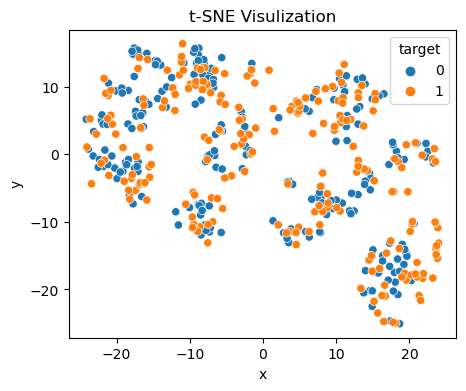

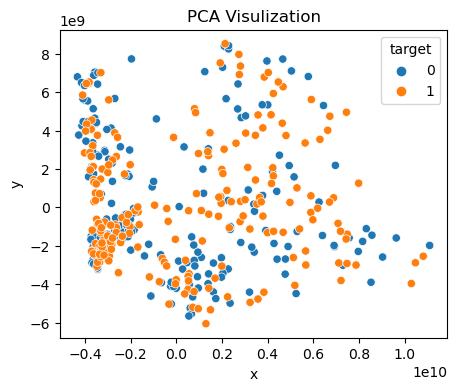

In [8]:
# Undersampling
rus = RandomUnderSampler(random_state=0)
X_underSampling, y_underSampling = rus.fit_resample(X, y)
print("X_underSampling's shape:", X_underSampling.shape,"y_underSampling's shape:", y_underSampling.shape)
print("y_underSampling:\n",y_underSampling.value_counts(normalize=True))
tSNE_visu(X_underSampling, y_underSampling)
PCA_visu(X_underSampling, y_underSampling)

### Oversampling

X_overSampling's shape: (13198, 95) y_overSampling's shape: (13198,)
y_overSampling:
 1    0.5
0    0.5
Name: target, dtype: float64


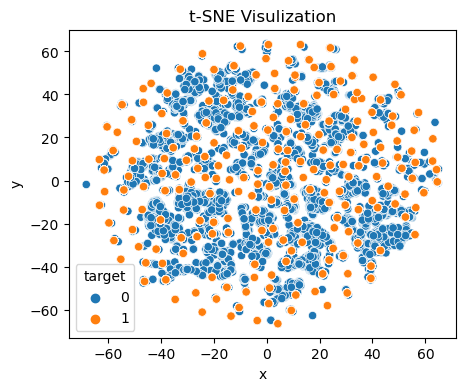

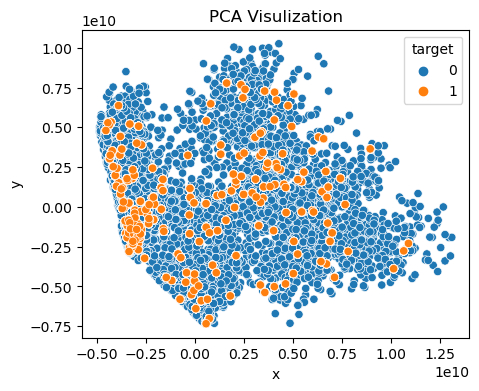

In [9]:
# Oversampling
ros = RandomOverSampler(random_state=0)
X_overSampling, y_overSampling = ros.fit_resample(X, y)
print("X_overSampling's shape:", X_overSampling.shape,"y_overSampling's shape:", y_overSampling.shape)
print("y_overSampling:\n",y_overSampling.value_counts(normalize=True))
tSNE_visu(X_overSampling, y_overSampling)
PCA_visu(X_overSampling, y_overSampling)

### SMOTE

X_SMOTE's shape: (13198, 95) y_SMOTE's shape: (13198,)
y_SMOTE:
 1    0.5
0    0.5
Name: target, dtype: float64


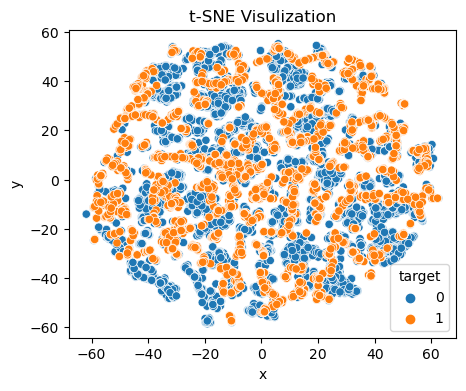

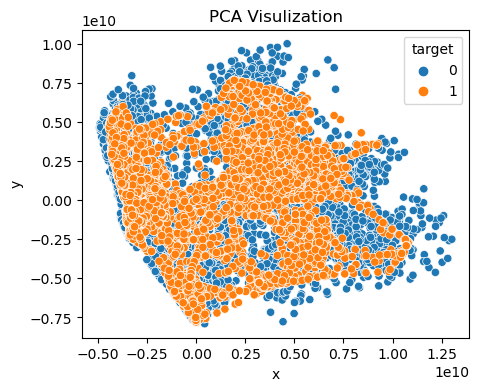

In [10]:
# SMOTE
sm = SMOTE(random_state=0)
X_SMOTE, y_SMOTE = sm.fit_resample(X, y)
print("X_SMOTE's shape:", X_SMOTE.shape,"y_SMOTE's shape:", y_SMOTE.shape)
print("y_SMOTE:\n",y_SMOTE.value_counts(normalize=True))
tSNE_visu(X_SMOTE, y_SMOTE)
PCA_visu(X_SMOTE, y_SMOTE)

### ADASYN

X_ADASYN's shape: (13122, 95) y_ADASYN's shape: (13122,)
y_ADASYN:
 0    0.502896
1    0.497104
Name: target, dtype: float64


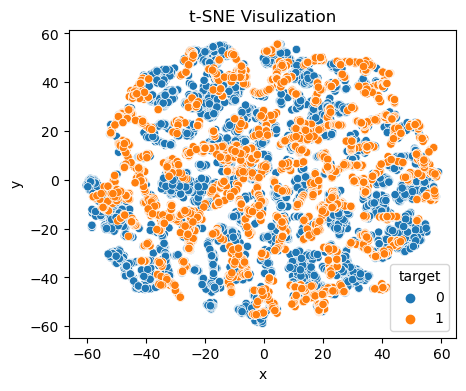

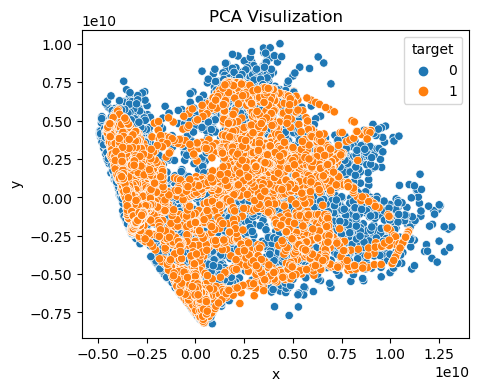

In [11]:
# ADASYN
adasym = ADASYN(random_state=0)
X_ADASYN, y_ADASYN = adasym.fit_resample(X, y)
print("X_ADASYN's shape:", X_ADASYN.shape,"y_ADASYN's shape:", y_ADASYN.shape)
print("y_ADASYN:\n",y_ADASYN.value_counts(normalize=True))
tSNE_visu(X_ADASYN, y_ADASYN)
PCA_visu(X_ADASYN, y_ADASYN)

In [49]:
def testModels(models, models_name, X, y, data_name, f1Score, acurrency):
    f1Score.loc[data_name] = np.zeros(len(models))
    acurrency.loc[data_name] = np.zeros(len(models))
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.3,
        random_state=42,
        stratify=y
        )
    for md_name, md in zip(models_name,models):
        md.fit(X_train,y_train)
        y_pre=md.predict(X_test)
        f1Score[md_name][data_name] = f1_score(y_test, y_pre, average='macro')
        acurrency[md_name][data_name] = accuracy_score(y_test, md.predict(X_test))


In [50]:
# Find the best resampled dataset
models = [RandomForestClassifier(), LogisticRegression(), AdaBoostClassifier(), DecisionTreeClassifier(), KNeighborsClassifier()]
models_name = ['RandomForestClassifier','LogisticRegression','AdaBoostClassifier','DecisionTreeClassifier','KNeighborsClassifier']
data_name = ['Original','underSampling','overSampling','SMOTE','ADASYN']
models_f1Score = pd.DataFrame(columns=models_name, index=data_name)
models_acurrency = pd.DataFrame(columns=models_name, index=data_name)

In [51]:
testModels(models, models_name, X, y, 'Original', models_f1Score, models_acurrency)
testModels(models, models_name, X_underSampling, y_underSampling, 'underSampling', models_f1Score, models_acurrency)
testModels(models, models_name, X_overSampling, y_overSampling, 'overSampling', models_f1Score, models_acurrency)
testModels(models, models_name, X_SMOTE, y_SMOTE, 'SMOTE', models_f1Score, models_acurrency)
testModels(models, models_name, X_ADASYN, y_ADASYN, 'ADASYN', models_f1Score, models_acurrency)

/Users/zoeychiu/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/zoeychiu/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

In [52]:
models_f1Score

,RandomForestClassifier,LogisticRegression,AdaBoostClassifier,DecisionTreeClassifier,KNeighborsClassifier
Original,0.604773,0.489011,0.653226,0.637085,0.491424
underSampling,0.840827,0.556969,0.833295,0.75752,0.58042
overSampling,0.994697,0.598001,0.948195,0.986614,0.950892
SMOTE,0.979288,0.607211,0.940151,0.950757,0.915221
ADASYN,0.977899,0.590111,0.941834,0.948945,0.909183


In [53]:
models_acurrency

,RandomForestClassifier,LogisticRegression,AdaBoostClassifier,DecisionTreeClassifier,KNeighborsClassifier
Original,0.969697,0.956989,0.967253,0.956012,0.966276
underSampling,0.840909,0.568182,0.833333,0.757576,0.583333
overSampling,0.994697,0.606566,0.948232,0.986616,0.95101
SMOTE,0.979293,0.614141,0.940152,0.950758,0.915657
ADASYN,0.977902,0.599441,0.941834,0.948946,0.909576


$\implies$ Choose "OverSampling" to start Feature Selection

In [54]:
X_resample = X_overSampling.copy()
y_resample = y_overSampling.copy()

# Feature Selectioon
- Removing features with missing values
- Removing features with low variance (0)
- Removing highly correlated features
- Selecting for Model Accuracy
- Selecting by Mutual Infromation

### Removing features with missing values

In [55]:
# check missing data
sum(X_resample.isna().sum()/len(y_resample))

0.0

$\implies$ no missing data

### Removing features with low variance (0)

data variance's description:
 count    9.500000e+01
mean     7.585769e+17
std      2.452095e+18
min      1.232689e-32
25%      2.721746e-04
50%      2.268530e-03
75%      2.865017e+14
max      1.147017e+19
dtype: float64


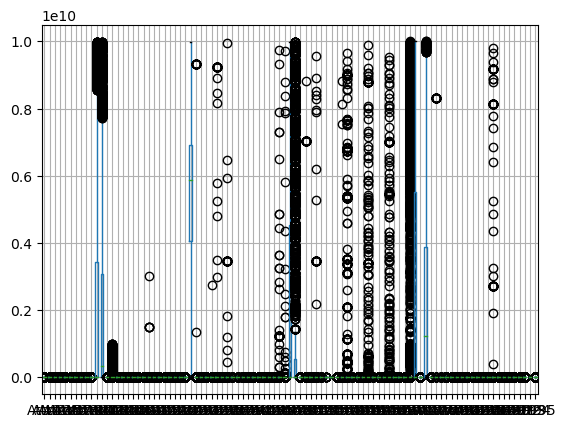

In [56]:
print("data variance's description:\n",X_resample.var().describe())
X_resample.boxplot()
plt.show()

normalized data variance's description:
 count       95.000000
mean       264.004802
std       1452.027592
min          0.000000
25%          0.003620
50%          0.041515
75%          2.518055
max      13197.998559
dtype: float64


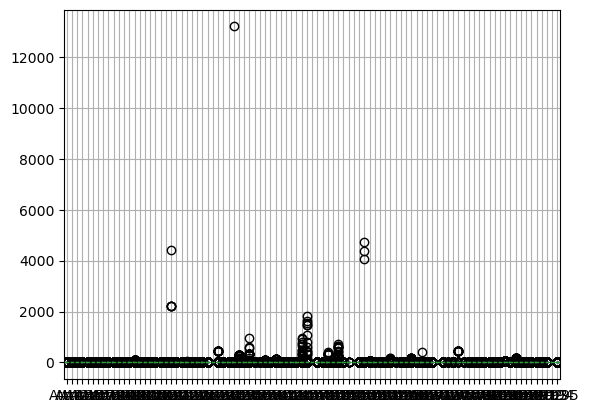

In [57]:
normalized_df = X_resample / X_resample.mean()
print("normalized data variance's description:\n",normalized_df.var().describe())
normalized_df.boxplot()
plt.show()

In [58]:
sel = VarianceThreshold(threshold=0)
sel.fit(normalized_df)
mask = sel.get_support()
data_removeZeroVairance = normalized_df.loc[:, mask]
print(X_resample.shape)
print(mask)
print(data_removeZeroVairance.shape)

(13198, 95)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True]
(13198, 94)


$\implies$ remove one feature with variance 0

In [59]:
testModels(models , models_name, data_removeZeroVairance, y_resample,'removeZeroVairance',models_f1Score, models_acurrency)
models_f1Score

/Users/zoeychiu/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,RandomForestClassifier,LogisticRegression,AdaBoostClassifier,DecisionTreeClassifier,KNeighborsClassifier
Original,0.604773,0.489011,0.653226,0.637085,0.491424
underSampling,0.840827,0.556969,0.833295,0.75752,0.58042
overSampling,0.994697,0.598001,0.948195,0.986614,0.950892
SMOTE,0.979288,0.607211,0.940151,0.950757,0.915221
ADASYN,0.977899,0.590111,0.941834,0.948945,0.909183
removeZeroVairance,0.994192,0.878272,0.934798,0.98535,0.958007


### Removing highly correlated features

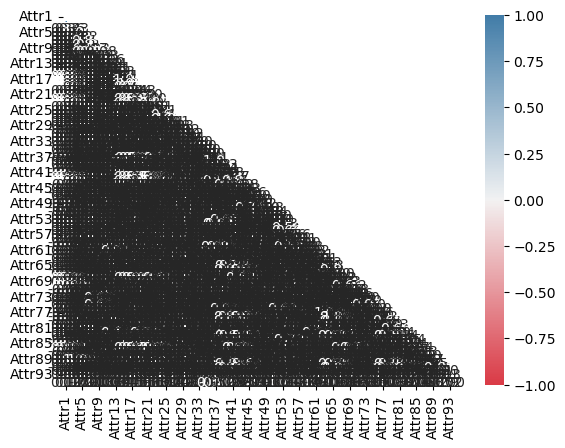

In [60]:
# The correlation matrix
# Create the correlation matrix
corr = X_resample.corr()
# Draw a heatmap of the correlation matrix
cmap = sns.diverging_palette(h_neg=10,h_pos=240,as_cmap=True)
# Generate a mask for the upper triangle 
mask = np.triu(np.ones_like(corr, dtype=bool))
# Add the mask to the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=1, annot=True, fmt=".2f")
plt.show()

In [61]:
# Calculate the correlation matrix and take the absolute value
corr_df = X_resample.corr().abs()
# Create a True/False mask and apply it
mask = np.triu(np.ones_like(corr_df, dtype=bool))
tri_df = corr_df.mask(mask)
# List column names of highly correlated features (r > 0.95)
to_drop = [c for c in tri_df.columns if any(tri_df[c] >  0.95)]
# Drop the features in the to_drop list
data_removeHighCorr = X_resample.drop(to_drop, axis=1)

print("drop columns of highly correlated features (r > 0.95)",to_drop)
print(f"\nThe reduced_df DataFrame has {data_removeHighCorr.shape[1]} columns.")


drop columns of highly correlated features (r > 0.95) ['Attr1', 'Attr2', 'Attr4', 'Attr5', 'Attr7', 'Attr8', 'Attr16', 'Attr17', 'Attr19', 'Attr22', 'Attr23', 'Attr26', 'Attr37', 'Attr40', 'Attr64', 'Attr66', 'Attr78']

The reduced_df DataFrame has 78 columns.


In [62]:
testModels(models , models_name, data_removeHighCorr, y_resample,'removeHighCorr',models_f1Score, models_acurrency)
models_f1Score

/Users/zoeychiu/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,RandomForestClassifier,LogisticRegression,AdaBoostClassifier,DecisionTreeClassifier,KNeighborsClassifier
Original,0.604773,0.489011,0.653226,0.637085,0.491424
underSampling,0.840827,0.556969,0.833295,0.75752,0.58042
overSampling,0.994697,0.598001,0.948195,0.986614,0.950892
SMOTE,0.979288,0.607211,0.940151,0.950757,0.915221
ADASYN,0.977899,0.590111,0.941834,0.948945,0.909183
removeZeroVairance,0.994192,0.878272,0.934798,0.98535,0.958007
removeHighCorr,0.995454,0.598001,0.93684,0.987372,0.950892


### Selecting for Model Accuracy
- StandardScaler
- LassoCV
- GradientBoostingRegressor
- RandomForestRegressor

In [63]:
scaler = StandardScaler()
# Fit the scaler on the training features and transform these in one go
X_resample_std = scaler.fit_transform(X_resample)

testModels(models , models_name, data_removeHighCorr, y_resample,'StandardScaler',models_f1Score, models_acurrency)
models_f1Score

/Users/zoeychiu/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,RandomForestClassifier,LogisticRegression,AdaBoostClassifier,DecisionTreeClassifier,KNeighborsClassifier
Original,0.604773,0.489011,0.653226,0.637085,0.491424
underSampling,0.840827,0.556969,0.833295,0.75752,0.58042
overSampling,0.994697,0.598001,0.948195,0.986614,0.950892
SMOTE,0.979288,0.607211,0.940151,0.950757,0.915221
ADASYN,0.977899,0.590111,0.941834,0.948945,0.909183
removeZeroVairance,0.994192,0.878272,0.934798,0.98535,0.958007
removeHighCorr,0.995454,0.598001,0.93684,0.987372,0.950892
StandardScaler,0.995202,0.598001,0.93684,0.987372,0.950892


In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resample,
    y_resample,
    test_size=0.3,
    random_state=42,
    stratify=y_resample
    )

In [65]:
# Create and fit the LassoCV model on the training set
lcv = LassoCV()
lcv.fit(X_train, y_train)
print(f'Optimal alpha = {lcv.alpha_:.3f}')

# Calculate R squared on the test set
r_squared = lcv.score(X_test, y_test)
print(f'The model explains {r_squared:.1%} of the test set variance')

# Create a mask for coefficients not equal to zero
lcv_mask = lcv.coef_ != 0
print(f'{sum(lcv_mask)} features out of {len(lcv_mask)} selected')


Optimal alpha = 248152.858
The model explains 8.9% of the test set variance
22 features out of 95 selected


In [66]:
# Select 10 features with RFE on a GradientBoostingRegressor, drop 3 features on each step
rfe_gb = RFE(estimator=GradientBoostingRegressor(), 
             n_features_to_select=10, step=10, verbose=1)
rfe_gb.fit(X_train, y_train)

Fitting estimator with 95 features.
Fitting estimator with 85 features.
Fitting estimator with 75 features.
Fitting estimator with 65 features.
Fitting estimator with 55 features.
Fitting estimator with 45 features.
Fitting estimator with 35 features.
Fitting estimator with 25 features.
Fitting estimator with 15 features.


RFE(estimator=GradientBoostingRegressor(), n_features_to_select=10, step=10,
    verbose=1)

In [67]:
# Print the features and their ranking (high = dropped early on)
#print(dict(zip(X_resample.columns, rfe_gb.ranking_)))

# Calculate the R squared on the test set
r_squared = rfe_gb.score(X_test, y_test)
print(f'The model can explain {r_squared:.1%} of the variance in the test set')

# Assign the support array to gb_mask
gb_mask = rfe_gb.support_

The model can explain 81.4% of the variance in the test set


In [68]:
# Select 10 features with RFE on a RandomForestRegressor, drop 3 features on each step
rfe_rf = RFE(estimator=RandomForestRegressor(), 
             n_features_to_select=10, step=10, verbose=1)
rfe_rf.fit(X_train, y_train)

Fitting estimator with 95 features.
Fitting estimator with 85 features.
Fitting estimator with 75 features.
Fitting estimator with 65 features.
Fitting estimator with 55 features.
Fitting estimator with 45 features.
Fitting estimator with 35 features.
Fitting estimator with 25 features.
Fitting estimator with 15 features.


RFE(estimator=RandomForestRegressor(), n_features_to_select=10, step=10,
    verbose=1)

In [69]:
# Print the features and their ranking (high = dropped early on)
#print(dict(zip(X_resample.columns, rfe_rf.ranking_)))
# Calculate the R squared on the test set
r_squared = rfe_rf.score(X_test, y_test)
print(f'The model can explain {r_squared:.1%} of the variance in the test set')
# Assign the support array to rf_mask
rf_mask = rfe_rf.support_

The model can explain 97.0% of the variance in the test set


In [70]:
scaler = StandardScaler()
lm = Lasso(alpha=248152.858)
# Sum the votes of the three models
votes = np.sum([lcv_mask, rf_mask, gb_mask], axis=0)
print("votes:",votes)
# Create a mask for features selected by at least 3 model
meta_mask = votes >= 2
# Apply the dimensionality reduction on X
X_reduced = X_resample.loc[:, meta_mask]
# Plug the reduced dataset into a linear regression pipeline
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y_resample, test_size=0.3, random_state=0)
lm.fit(scaler.fit_transform(X_train_reduced), y_train_reduced)
r_squared = lm.score(scaler.transform(X_test_reduced), y_test_reduced)
print(f'The model can explain {r_squared:.1%} of the variance in the test set using {len(lm.coef_)} features.')

votes: [0 0 0 0 0 0 0 0 2 2 1 1 0 1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 1 0 0 0 2 2 3 0
 0 0 2 0 0 0 0 0 2 1 1 1 0 1 0 2 0 0 0 1 1 1 0 0 0 2 0 0 0 1 1 0 0 1 1 0 2
 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0]
The model can explain -0.2% of the variance in the test set using 11 features.


$\implies$ the perfoemance is low

In [71]:
testModels(models , models_name, X_reduced, y_resample,'modelReduceFeature',models_f1Score, models_acurrency)
models_f1Score

,RandomForestClassifier,LogisticRegression,AdaBoostClassifier,DecisionTreeClassifier,KNeighborsClassifier
Original,0.604773,0.489011,0.653226,0.637085,0.491424
underSampling,0.840827,0.556969,0.833295,0.75752,0.58042
overSampling,0.994697,0.598001,0.948195,0.986614,0.950892
SMOTE,0.979288,0.607211,0.940151,0.950757,0.915221
ADASYN,0.977899,0.590111,0.941834,0.948945,0.909183
removeZeroVairance,0.994192,0.878272,0.934798,0.98535,0.958007
removeHighCorr,0.995454,0.598001,0.93684,0.987372,0.950892
StandardScaler,0.995202,0.598001,0.93684,0.987372,0.950892
modelReduceFeature,0.993182,0.364418,0.923429,0.988382,0.945801


### Selecting by Mutual Infromation

Text(0, 0.5, 'Mutual Information')

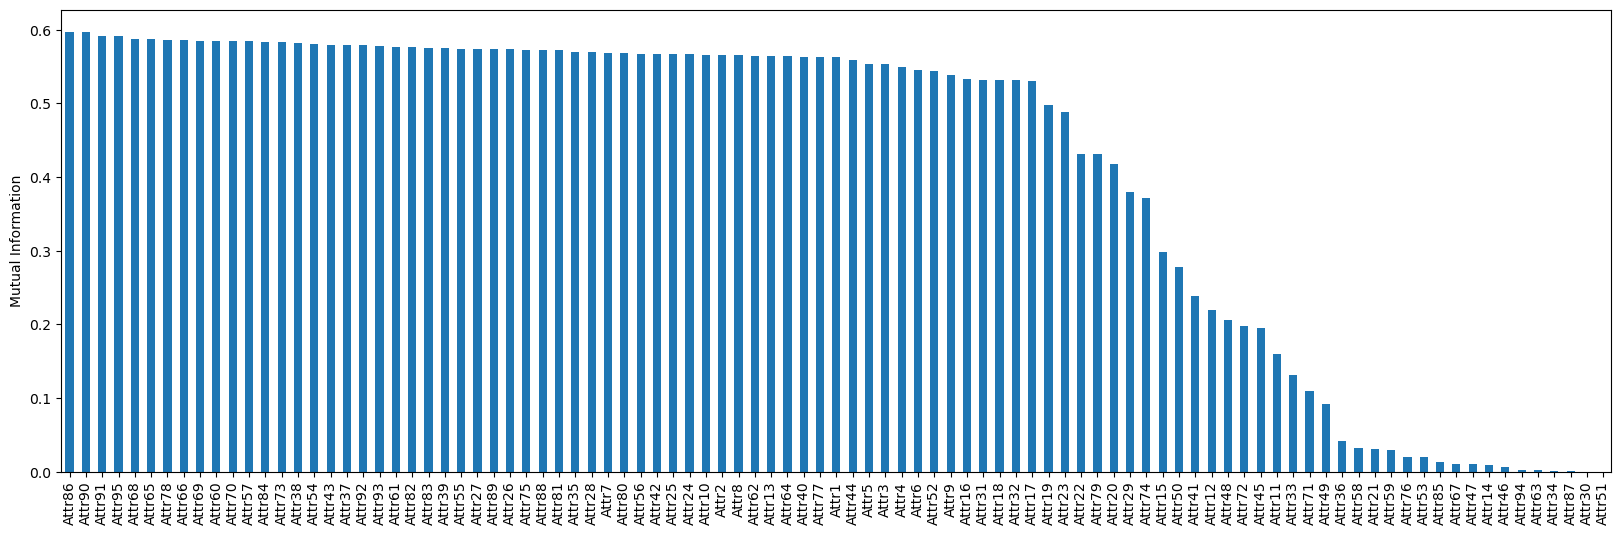

In [72]:
# the less mi value, the less information we can get from
mi = mutual_info_classif(X_resample, y_resample)
miseries = pd.Series(mi)
miseries.index = X_resample.columns
miseries.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel('Mutual Information')

In [73]:
# select features
k_best = SelectKBest(mutual_info_classif, k=40).fit(X_resample, y_resample)
X_kBest = k_best.transform(X_resample)
# display features
#X_resample.columns[k_best.get_support()]

In [74]:
testModels(models, models_name, X_kBest, y_resample,'kBestMutualInfo',models_f1Score, models_acurrency)
models_f1Score

/Users/zoeychiu/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,RandomForestClassifier,LogisticRegression,AdaBoostClassifier,DecisionTreeClassifier,KNeighborsClassifier
Original,0.604773,0.489011,0.653226,0.637085,0.491424
underSampling,0.840827,0.556969,0.833295,0.75752,0.58042
overSampling,0.994697,0.598001,0.948195,0.986614,0.950892
SMOTE,0.979288,0.607211,0.940151,0.950757,0.915221
ADASYN,0.977899,0.590111,0.941834,0.948945,0.909183
removeZeroVairance,0.994192,0.878272,0.934798,0.98535,0.958007
removeHighCorr,0.995454,0.598001,0.93684,0.987372,0.950892
StandardScaler,0.995202,0.598001,0.93684,0.987372,0.950892
modelReduceFeature,0.993182,0.364418,0.923429,0.988382,0.945801
kBestMutualInfo,0.993434,0.870675,0.936047,0.987119,0.970935


In [75]:
models_acurrency

,RandomForestClassifier,LogisticRegression,AdaBoostClassifier,DecisionTreeClassifier,KNeighborsClassifier
Original,0.969697,0.956989,0.967253,0.956012,0.966276
underSampling,0.840909,0.568182,0.833333,0.757576,0.583333
overSampling,0.994697,0.606566,0.948232,0.986616,0.95101
SMOTE,0.979293,0.614141,0.940152,0.950758,0.915657
ADASYN,0.977902,0.599441,0.941834,0.948946,0.909576
removeZeroVairance,0.994192,0.878283,0.934848,0.985354,0.958081
removeHighCorr,0.995455,0.606566,0.936869,0.987374,0.95101
StandardScaler,0.995202,0.606566,0.936869,0.987374,0.95101
modelReduceFeature,0.993182,0.392677,0.923485,0.988384,0.94596
kBestMutualInfo,0.993434,0.870707,0.936111,0.987121,0.97096


$\implies$ choose dataset: kBestMutualInfo and model "RandomForestClassifier"

# Using cross-validation to evaluate our models

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
randomForest_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                      ("tree", DecisionTreeClassifier(random_state=10))])


# Set up our K-fold cross-validation
kf = KFold(10)

# Train our models using KFold cv
randomForest_pipe = cross_val_score(tree_pipe, features, labels, cv=kf)

# Print the mean of each array of scores
print("Decision Tree:", tree_score, "Logistic Regression:", logit_score)

### LogisticRegression

LogisticRegression predict X_test:  [0 0 0 ... 0 0 0]

LogisticRegression score 0.958455522971652

LogisticRegression AUC score: 0.5910

LogisticRegression confusion matrix
 [[1961   19]
 [  66    0]]


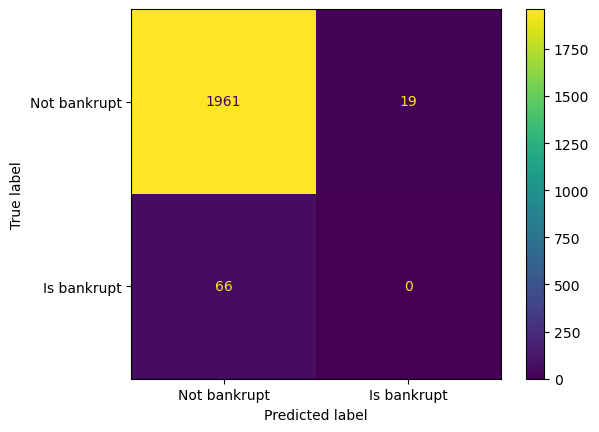

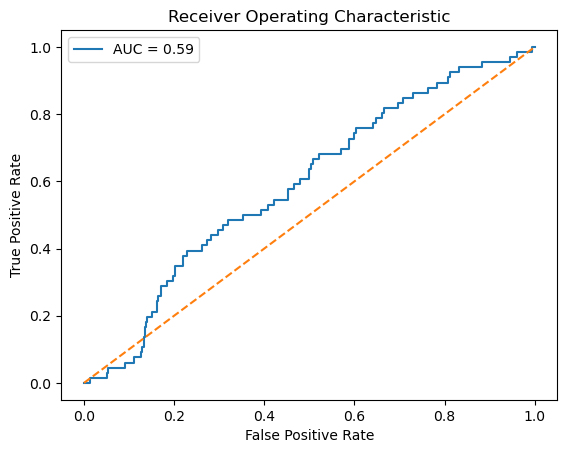

In [17]:
# Importing modules
from sklearn import linear_model

# Instantiate LogisticRegression
logreg = linear_model.LogisticRegression(
    solver='liblinear',
    random_state=42
)

# Train the model
logreg.fit(X_train, y_train)
logreg_predict = logreg.predict(X_test)
print("LogisticRegression predict X_test: ",logreg_predict)
print("\nLogisticRegression score",logreg.score(X_test, y_test))

# AUC score for logistic regression model
logreg_auc_score = roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])
print(f'\nLogisticRegression AUC score: {logreg_auc_score:.4f}')

#print confusion matrix
c_matrix = confusion_matrix(y_test,logreg_predict)
print("\nLogisticRegression confusion matrix\n",c_matrix)
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix,display_labels=["Not bankrupt", "Is bankrupt"])
disp.plot()
plt.show()

logreg_probabilities = logreg.predict_proba(X_test)
ROC_AUC_Curve(logreg_probabilities,y_test)

LogisticRegression K_best predict X_test_best:  [0 0 0 ... 0 0 0]

LogisticRegression K_best score 0.969208211143695

LogisticRegression K_best AUC score: 0.9268

LogisticRegression K_best confusion matrix
 [[1979    1]
 [  62    4]]


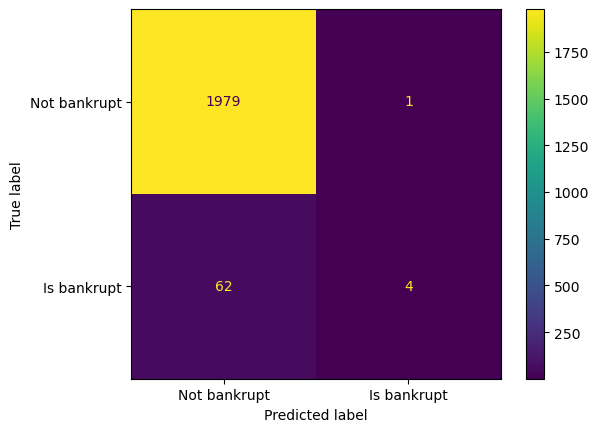

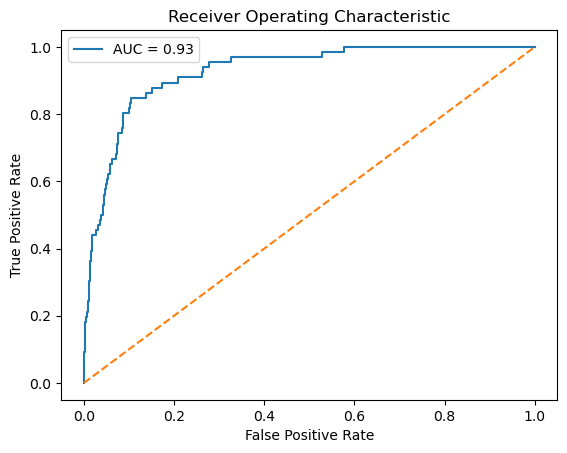

In [18]:
# Instantiate LogisticRegression
logreg_best = linear_model.LogisticRegression(
    solver='liblinear',
    random_state=42
)

# Train the model
logreg_best.fit(X_train_best, y_train_best)
logreg_best_predict = logreg_best.predict(X_test_best)
print("LogisticRegression K_best predict X_test_best: ",logreg_best_predict)
print("\nLogisticRegression K_best score",logreg_best.score(X_test_best, y_test_best))

# AUC score for logistic regression model
logreg_auc_score_best = roc_auc_score(y_test_best, logreg_best.predict_proba(X_test_best)[:,1])
print(f'\nLogisticRegression K_best AUC score: {logreg_auc_score_best:.4f}')

#print confusion matrix
c_matrix = confusion_matrix(y_test_best,logreg_best_predict)
print("\nLogisticRegression K_best confusion matrix\n",c_matrix)
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix,display_labels=["Not bankrupt", "Is bankrupt"])
disp.plot()
plt.show()

logreg_best_probabilities = logreg_best.predict_proba(X_test_best)
ROC_AUC_Curve(logreg_best_probabilities,y_test_best)

### KNeighborsClassifier

KNeighborsClassifier predict X_test:  [0 0 0 ... 0 0 0]

KNeighborsClassifier score 0.966275659824047

AUC score: 0.6122

KNeighborsClassifier confusion matrix
 [[1977    3]
 [  66    0]]


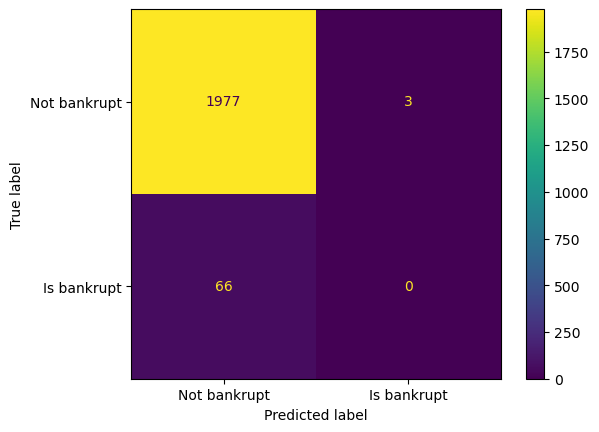

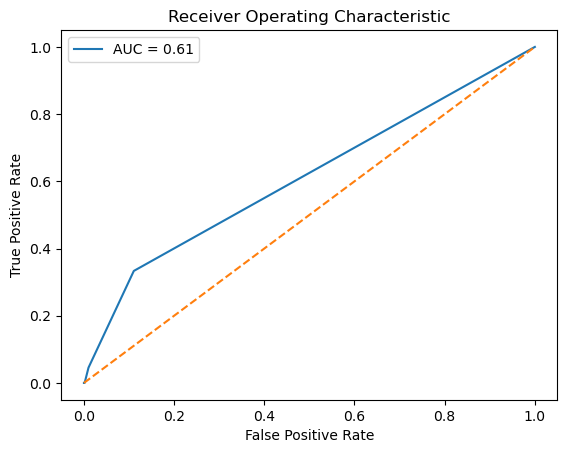

In [19]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_predict = knn.predict(X_test)
print("KNeighborsClassifier predict X_test: ",knn_predict)
print("\nKNeighborsClassifier score",knn.score(X_test, y_test))

# AUC score for KNeighborsClassifier model
knn_auc_score = roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])
print(f'\nAUC score: {knn_auc_score:.4f}')

#print confusion matrix
c_matrix = confusion_matrix(y_test,knn_predict)
print("\nKNeighborsClassifier confusion matrix\n",c_matrix)
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix,display_labels=["Not bankrupt", "Is bankrupt"])
disp.plot()
plt.show()

knn_probabilities = knn.predict_proba(X_test)
ROC_AUC_Curve(knn_probabilities,y_test)

KNeighborsClassifier K_Best predict X_test:  [0 0 0 ... 0 0 0]

KNeighborsClassifier K_Best score 0.9652981427174976

AUC K_Best score: 0.7651

KNeighborsClassifier K_Best confusion matrix
 [[1967   13]
 [  58    8]]


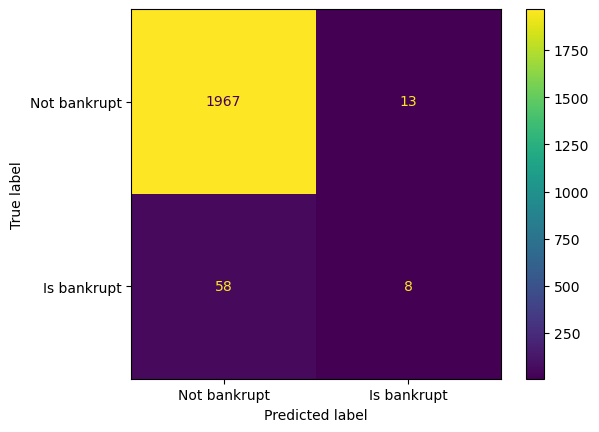

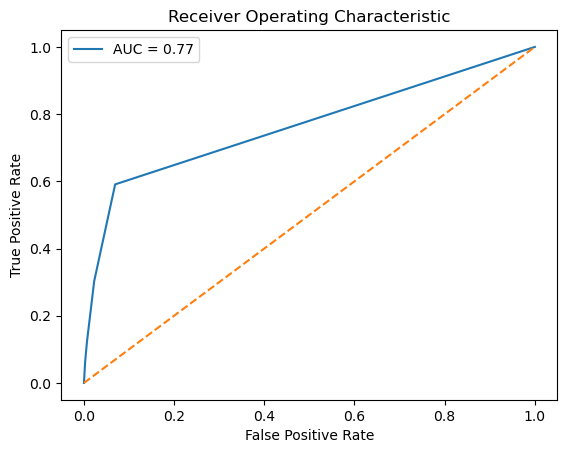

In [20]:
knn_best = KNeighborsClassifier()
knn_best.fit(X_train_best, y_train_best)
knn_best_predict = knn_best.predict(X_test_best)
print("KNeighborsClassifier K_Best predict X_test: ",knn_best_predict)
print("\nKNeighborsClassifier K_Best score",knn_best.score(X_test_best, y_test_best))

# AUC score for KNeighborsClassifier model
knn_auc_score_best = roc_auc_score(y_test_best, knn_best.predict_proba(X_test_best)[:,1])
print(f'\nAUC K_Best score: {knn_auc_score_best:.4f}')

#print confusion matrix
c_matrix = confusion_matrix(y_test_best,knn_best_predict)
print("\nKNeighborsClassifier K_Best confusion matrix\n",c_matrix)
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix,display_labels=["Not bankrupt", "Is bankrupt"])
disp.plot()
plt.show()

knn_best_probabilities = knn_best.predict_proba(X_test_best)
ROC_AUC_Curve(knn_best_probabilities,y_test)

## LinearSVC

LinearSVC predict X_test:  [0 0 0 ... 0 0 0]

LinearSVC score 0.967741935483871

LinearSVC accuracy_score score: 0.6359

LinearSVC confusion matrix
 [[1980    0]
 [  66    0]]


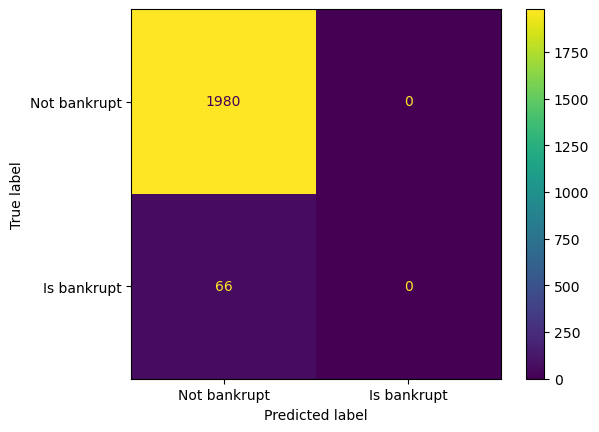

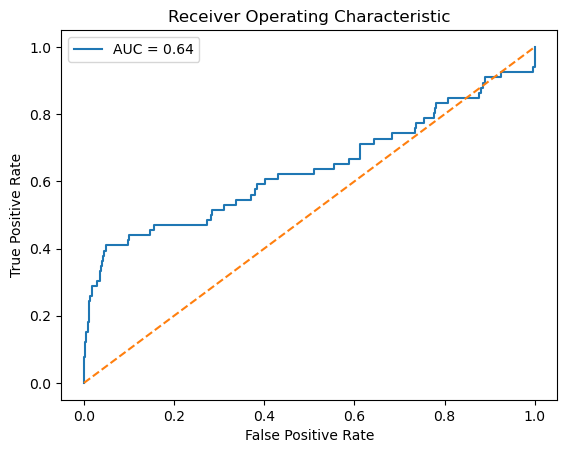

In [ ]:
from sklearn.svm import SVC

svm_best = SVC(kernel = 'linear', probability = True,random_state=42)
svm_best.fit(X_train_best, y_train_best)
svm_best_predict = svm_best.predict(X_test_best)
print("LinearSVC predict X_test: ",svm_best_predict)
print("\nLinearSVC score",svm_best.score(X_test_best, y_test_best))

# AUC score for logistic KNeighborsClassifier model
svm_auc_score_best = roc_auc_score(y_test_best, svm_best.predict_proba(X_test_best)[:,1])
print(f'\nLinearSVC accuracy_score score: {svm_auc_score_best:.4f}')

#print confusion matrix
c_matrix = confusion_matrix(y_test_best,svm_best_predict)
print("\nLinearSVC confusion matrix\n",c_matrix)
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix,display_labels=["Not bankrupt", "Is bankrupt"])
disp.plot()
plt.show()


svm_best_probabilities = svm_best.predict_proba(X_test_best)
ROC_AUC_Curve(svm_best_probabilities,y_test_best)


# Model Complexity Review
- Underfiiting: model is too simple, low training accurancy
- Overfitting: model is too complex, low test accruancy

In [10]:
classifiers = [LogisticRegression(),SVC(kernel = 'linear', probability = True,random_state=42),KNeighborsClassifier()]
model_titles = ('LogisticRegression','LinearSVC','KNeighborsClassifier')
print("AUC score before imberlearn:")
for cl, title in zip(classifiers, model_titles):
    cl.fit(X_train_best, y_train_best)
    print(title+":",roc_auc_score(y_test_best, cl.predict_proba(X_test_best)[:,1]))
    
classifiers_2 = [LogisticRegression(),KNeighborsClassifier()]
model_titles_2 = ('LogisticRegression','KNeighborsClassifier')

AUC score before imberlearn:
LogisticRegression: 0.9244490358126722
LinearSVC: 0.7940541781450872
KNeighborsClassifier: 0.7650443832262014


## Balanced Random Forest 
i. For each iteration in the random forest algorithm, it takes a bootstrap sample from the minority class and the same number of data points form the majority class with replacements.

ii. Induce a classification tree using the CART algorithm to its maximum size without pruning and at each node search form randomly selected variables for the optimal split.

iii. Repeat these two steps above for the desired number of times and aggregate the results to make the final prediction.

Before implementing this algorithm I split the dataset into 10 splits using StratifiedKFold and then apply BalancedRandomForestClassifier.

In [9]:
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=202020)
for fold, (tr_ind, val_ind) in enumerate(X, y):
    X_train_kfold, X_val_kfold     = X.iloc[tr_ind], X.iloc[val_ind]
    y_train_kfold, y_val_kfold     = y.iloc[tr_ind], y.iloc[val_ind]
    model1 = BalancedRandomForestClassifier(n_estimators = 50,
                                            max_depth=7,
                                            min_samples_split = 3,
                                            bootstrap= True,
                                            min_samples_leaf=1,random_state=202020)
    model1.fit(X_train_kfold,y_train_kfold)
    val_pred1_kfold = model1.predict(X_val_kfold)
    print('AUC score -',fold+1,': ',roc_auc_score(y_val_kfold,val_pred1_kfold))

TypeError: 'Series' object cannot be interpreted as an integer